In [52]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
import numpy as np
import random
import scipy
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"
import gc


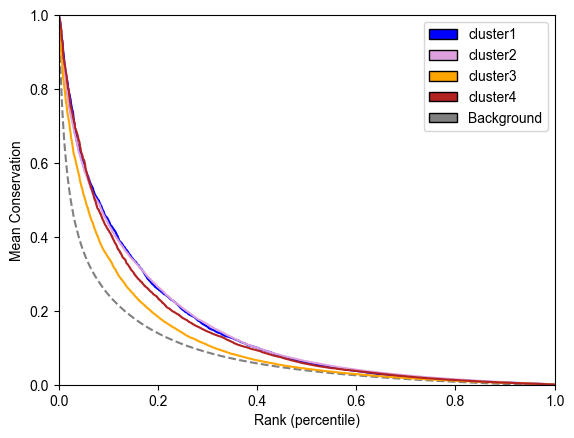

In [65]:
outdir = 'fig5/'
os.makedirs(outdir,exist_ok=True)
workdir = outdir+'/tmp/'
os.makedirs(workdir,exist_ok=True)

phastcon = 'hg38.phastCons100way.bw' # phastcons100way is vertibrates
background = 'background.conservation.bed'
new = False

if not os.path.isfile(background) or new:
    command = f"./bigWigAverageOverBed {phastcon} background.bed {background}"
    os.system(command)


p2c = pd.read_excel('Fig5_ATAC_peaks.xlsx',sheet_name='peak_clusters')
clusters = sorted(list(set(p2c['Cluster'])))
for cluster in clusters:
    input = workdir+cluster+'.bed'
    output = workdir+cluster+'.conservation.bed'

    if not os.path.isfile(input) or new:
        with open(input,'w+') as f:
            peaks = '\n'.join(p2c.loc[p2c['Cluster']==cluster,'PeakID'].apply(lambda x: x.replace(':','\t').replace('-','\t')+'\t'+x))
            f.write(peaks)
    
    if not os.path.isfile(output) or new:
        command = f"./bigWigAverageOverBed {phastcon} {input} {output}"
        os.system(command)


show = 'rank'


match show:
    case 'cdf':
        df = pd.read_csv('background.conservation.bed',sep='\t',names=['name','size','covered','sum','mean0','mean'])
        yvals = list(df['mean'])
        yvals.sort()
        n = 1000
        x,y,step,ystep,on=[0],[0],1/n,1/len(yvals),1/n
        for v in yvals:
            while v >= on:
                y.append(y[-1])
                on += step
                x.append(on)
            y[-1] += ystep
        plt.plot(x,y,'--',color='gray',)
    case 'rank':
        df = pd.read_csv('background.conservation.bed',sep='\t',names=['name','size','covered','sum','mean0','mean'])
        yvals = list(df['mean'])
        yvals.sort()
        ranks = np.linspace(1,0,len(yvals))
        plt.plot(ranks,yvals,'--',color='gray',)
    case 'bar':
        colors = [
            'b',
            'plum',
            'orange',
            'firebrick',
        ]
        nbins = 5
        binEdges = np.array([i/nbins for i in range(nbins+1)])
        bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
        binsize = 0.5
        cats = len(clusters)
        width = 1/cats*binsize/nbins
        binstart = width/binsize/2
        xstart = bincenters-binstart*2
        ctrl = pd.read_csv(background,sep='\t',names=['name','size','covered','sum','mean0','mean'])
        cvals = np.array(ctrl['mean'])
        ctrltrue,_ = np.histogram(cvals,bins=binEdges)
        ctrlerr = np.sqrt(ctrltrue*(1-ctrltrue/ctrltrue.sum()))*100/ctrltrue.sum()
        ctrltrue = ctrltrue*100/ctrltrue.sum()
for loc,cluster in enumerate(clusters):
    df = pd.read_csv(workdir+cluster+'.conservation.bed',sep='\t',names=['name','size','covered','sum','mean0','mean'])
    yvals = list(df['mean'])
    yvals.sort()

    match show:
        case 'bar':
            yvals = np.array(df['mean'])
            print(cluster,'has',(yvals >= 0.5).sum(),'conserved and',(yvals < 0.5).sum(),'not conserved')
            ytrue,_ = np.histogram(yvals,bins=binEdges)
            x = xstart + loc*width
            yerr = np.sqrt(ytrue*(1-ytrue/ytrue.sum()))*100/ytrue.sum()
            ytrue = ytrue*100/ytrue.sum()
            rtrue = ytrue/ctrltrue
            rerr = rtrue * np.sqrt((yerr/ytrue)**2 + (ctrlerr/ctrltrue)**2)
            plt.bar(x, rtrue, width=width, color=colors[loc], yerr=rerr, edgecolor = 'k',capsize=5)
        case 'cdf':
            n = 1000
            x,y,step,ystep,on=[0],[0],1/n,1/len(yvals),1/n
            for v in yvals:
                while v >= on:
                    y.append(y[-1])
                    on += step
                    x.append(on)
                y[-1] += ystep
            plt.plot(x,y,colors[loc])
        case 'rank':
            ranks = np.linspace(1,0,len(yvals))
            plt.plot(ranks,yvals,colors[loc])

handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in colors]
labels = list(clusters)
match show:
    case 'bar':
        plt.yscale('log')
        plt.xlabel('Mean Conservation')
        plt.xlim([0,1])
    case 'cdf':
        plt.ylabel('P(Conservation < ___)')
        plt.xlabel('Mean Conservation')
        plt.ylim([0,1])
        plt.xlim([1,0])
        labels.append('Background')
        handles.append(Rectangle((0,0),1,1,color='gray',ec="k"))
    case 'rank':
        plt.xlabel('Rank (percentile)')
        plt.ylabel('Mean Conservation')
        plt.xlim([0,1])
        plt.ylim([0,1])
        labels.append('Background')
        handles.append(Rectangle((0,0),1,1,color='gray',ec="k"))
plt.legend(handles, labels,)
plt.savefig(outdir+'ConservationInfoFig5_ATAC.fold_change.conservation.pdf')
plt.show()
